# New World Wonder Classification with CNNs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory

# remove warnings
import warnings
warnings.filterwarnings('ignore')

## Load dataset

In [2]:
# Loading images into training and validation datasets

BATCH_SIZE = 32
IMG_SIZE = (200, 250)
directory = "data/Wonders of World"
train_images = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_images = image_dataset_from_directory(directory,
                                                    shuffle=True,
                                                    batch_size=BATCH_SIZE,
                                                    image_size=IMG_SIZE,
                                                    validation_split=0.2,
                                                    subset='validation',
                                                    seed=42)

Found 3846 files belonging to 12 classes.
Using 3077 files for training.
Found 3846 files belonging to 12 classes.
Using 769 files for validation.


In [3]:
class_names = train_images.class_names
print(class_names)

['burj_khalifa', 'chichen_itza', 'christ_the_reedemer', 'eiffel_tower', 'great_wall_of_china', 'machu_pichu', 'pyramids_of_giza', 'roman_colosseum', 'statue_of_liberty', 'stonehenge', 'taj_mahal', 'venezuela_angel_falls']


In [4]:
# get count of images per class
train_class_count = [0 for i in range(len(class_names))]
for _, labels_batch in train_images:
    for i in range(len(labels_batch)):
        train_class_count[labels_batch[i]] += 1
train_class_count = {class_names[i]: train_class_count[i] for i in range(len(class_names))}

validation_class_count = [0 for i in range(len(class_names))]
for _, labels_batch in validation_images:
    for i in range(len(labels_batch)):
        validation_class_count[labels_batch[i]] += 1
validation_class_count = {class_names[i]: validation_class_count[i] for i in range(len(class_names))}

for i in range(len(class_names)):
    print(f"Class {class_names[i]} has {train_class_count[class_names[i]]} training images and {validation_class_count[class_names[i]]} validation images")

Class burj_khalifa has 329 training images and 61 validation images
Class chichen_itza has 270 training images and 70 validation images
Class christ_the_reedemer has 259 training images and 64 validation images
Class eiffel_tower has 311 training images and 80 validation images
Class great_wall_of_china has 305 training images and 87 validation images
Class machu_pichu has 330 training images and 63 validation images
Class pyramids_of_giza has 304 training images and 68 validation images
Class roman_colosseum has 310 training images and 84 validation images
Class statue_of_liberty has 183 training images and 55 validation images
Class stonehenge has 164 training images and 40 validation images
Class taj_mahal has 124 training images and 34 validation images
Class venezuela_angel_falls has 188 training images and 63 validation images


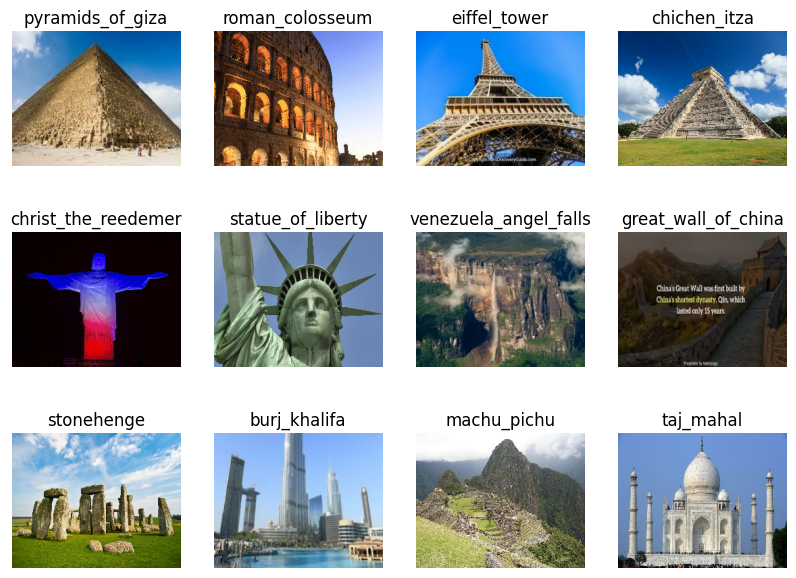

In [5]:
classes = class_names.copy()
figure_count = 0

plt.figure(figsize=(10, 10))
for images, labels in train_images:
    if len(classes) == 0:
        break
    for i in range(len(labels)):
        if len(classes) == 0:
            break
        if not class_names[labels[i]] in classes:
            continue
        ax = plt.subplot(4, 4, figure_count + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
        classes.remove(class_names[labels[i]])
        figure_count += 1


## Data Augmentation and Preprocessing

In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_images = train_images.prefetch(buffer_size=AUTOTUNE)

In [7]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    tfl.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tfl.experimental.preprocessing.RandomRotation(0.2),
])

Text(0.5, 0.98, 'Augmented images')

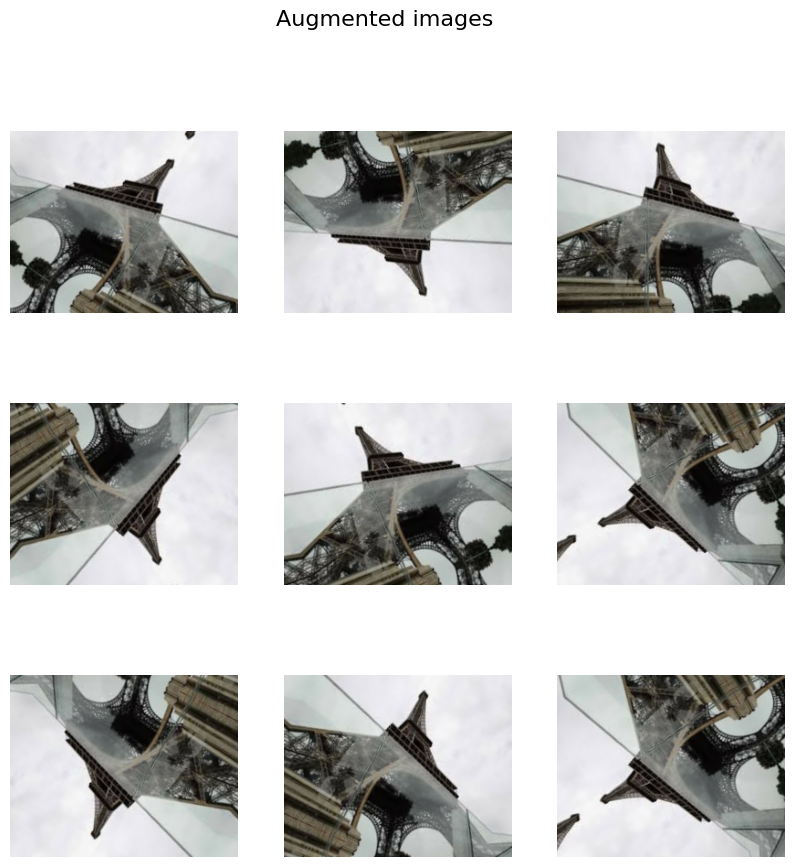

In [8]:
# Visualize augmented images
tf.get_logger().setLevel('ERROR')

fig = plt.figure(figsize=(10, 10))
for images, _ in train_images.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")
fig.suptitle("Augmented images", fontsize=16)

In [9]:
# We will be using mobilenet_v2 as our base model, so we need to preprocess the images accordingly

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

## Model creation

In [10]:
# Load mobilenet_v2 model
INPUT_SHAPE = IMG_SIZE + (3,)

def create_model(input_shape=INPUT_SHAPE, num_classes=len(class_names)):
    base_model = tf.keras.applications.MobileNetV2(input_shape=INPUT_SHAPE, include_top=False, weights='imagenet')
    base_model.trainable = False
    
    inputs = tf.keras.Input(shape=input_shape)

    x = data_augmentation(inputs)
    x = preprocess_input(x)

    x = base_model(x, training=False)
    x = tfl.GlobalAveragePooling2D()(x)
    x = tfl.Dropout(0.2)(x)

    outputs = tfl.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)

    return model

In [11]:
model = create_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 250, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 200, 250, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 200, 250, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 200, 250, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 8, 1280)       2257984   
 ional)                                                          
                                                             

In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

### Class weights to account for class imbalance

In [13]:
class_weights = {i: (1 / train_class_count[class_names[i]]) * (sum(train_class_count.values()) / 2) for i in range(len(class_names))}
print(class_weights)

{0: 4.67629179331307, 1: 5.698148148148149, 2: 5.940154440154441, 3: 4.946945337620579, 4: 5.0442622950819676, 5: 4.662121212121212, 6: 5.060855263157895, 7: 4.962903225806452, 8: 8.407103825136613, 9: 9.38109756097561, 10: 12.407258064516128, 11: 8.183510638297872}


### Training

In [ ]:
EPOCHS = 10
history = model.fit(train_images, epochs=EPOCHS, validation_data=validation_images, class_weight=class_weights)

### Results

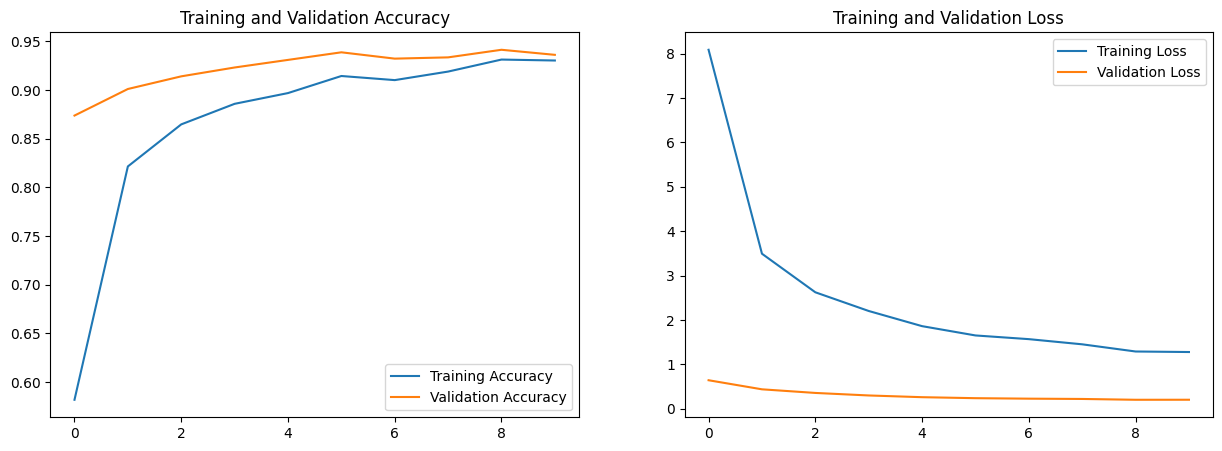

In [ ]:
# plot training and validation accuracy and loss

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Save model

In [32]:
model.save('model.h5')

### Example predictions

In [30]:
# Load model
model = tf.keras.models.load_model('model.h5')

1/1 [==============================] - 0s 61ms/step


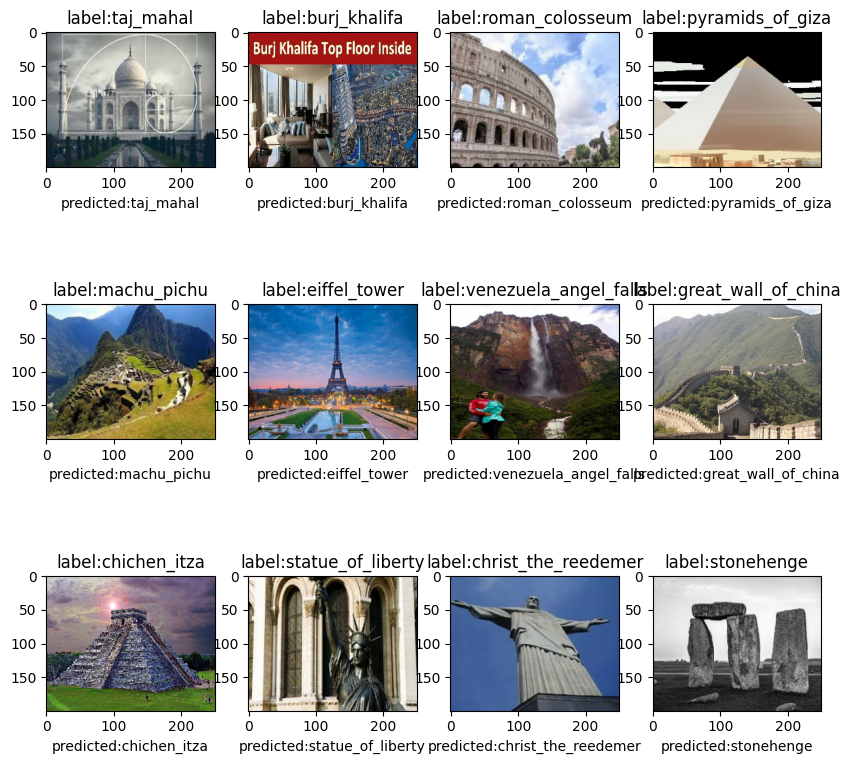

In [35]:
classes = class_names.copy()
figure_count = 0

plt.figure(figsize=(10, 10))
for images, labels in validation_images:
    if len(classes) == 0:
        break
    for i in range(len(labels)):
        if len(classes) == 0:
            break
        if not class_names[labels[i]] in classes:
            continue
        
        ax = plt.subplot(3, 4, figure_count + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("label:" + class_names[labels[i]])

        predicted_label = np.argmax(model.predict(images[i][np.newaxis, ...]))
        plt.xlabel("predicted:" + class_names[predicted_label])
        
        classes.remove(class_names[labels[i]])
        figure_count += 1